# **Financial Modelling** 







***Student Assignment***
* For Academic Purposes Only. This is a fictional prospectus created for the Financial Modeling course at Nova SBE. Not an offer to sell securities.

<BR>

<small><em>
**Disclaimer:** Following the rules of the assignment AI policy, we used ChatGPT solely for minor readability adjustments, such as reformatting long lines or renaming variables when appropriate. All the rationale, coding logic and application was created by ourselves.
</em></small>




# 1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

#2 Setup
Sets parameters. Initially an equally weighted allocation is used as synthetic benchmark.

In [2]:
ASSETS = ["SPY", "QUAL", "USMV", "VLUE", "MTUM", "SIZE", "GLD", "SMH", "EEM"]
BENCHMARK_WEIGHTS = {a: 0.2 if a == "SPY" else 0.1 for a in ASSETS}
START_DATE, END_DATE = "2013-08-01", "2025-10-31"
LOOKBACK, VOL_CAP, ANNUAL_FEE = 126, 0.30, 0.0069

#3 Fetch/Prepare Data
Historical asset returns from Yahoo Finance where IRX is used as risk free rate in the Sharpe Ratio construction

In [3]:
prices = yf.download(ASSETS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)['Close']
rf_raw = yf.download("^IRX", start=START_DATE, end=END_DATE, auto_adjust=False, progress=False)['Close']

returns = prices.ffill().pct_change().dropna(how="all")
rf_daily = ((1 + rf_raw / 100) ** (1/252) - 1).reindex(returns.index).ffill().squeeze()
returns, rf_daily = returns.loc[rf_daily.notna()], rf_daily.loc[rf_daily.notna()]
excess_returns = returns.sub(rf_daily, axis=0)

print(f"Range: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Assets: {sorted(ASSETS)}")
print(f"Rows: {len(returns)}")

Range: 2013-08-02 to 2025-10-30
Assets: ['EEM', 'GLD', 'MTUM', 'QUAL', 'SIZE', 'SMH', 'SPY', 'USMV', 'VLUE']
Rows: 3081


#4 TCP Function
Maximes Sharpe ratio weight with long-only constraint to create Tangency Portfolio.

In [4]:
def tangency_weights(mu_e, cov):
    n = len(mu_e)
    mu, C = mu_e.values * 252, cov.values * 252 + np.eye(n) * 0.000001
    obj = lambda w: -w.dot(mu) / np.sqrt(w.dot(C).dot(w) + 0.000001)
    res = minimize(obj, np.ones(n)/n, bounds=[(0,1)]*n, constraints={"type":"eq","fun":lambda w: w.sum()-1})
    return pd.Series(res.x, index=mu_e.index)

#5 Backtest with Monthly Rebalancing and Vol Cap
Simulate strategy using monthly rebalancing with lookback window and ex-ante volatility cap.

In [5]:
weights = pd.DataFrame(0.0, index=returns.index, columns=sorted(ASSETS))
reb_dates = [returns.index[returns.index.get_indexer([d], method="pad")[0]]
             for d in returns.resample("BME").last().index
             if returns.index.get_indexer([d], method="pad")[0] >= LOOKBACK]
reb_dates = sorted(pd.unique(pd.to_datetime(reb_dates)))

rebalance_info = []
for i, date in enumerate(reb_dates):
    idx = returns.index.get_loc(date)
    window = slice(idx - LOOKBACK, idx)

    valid = excess_returns.iloc[window].dropna(axis=1).columns
    if len(valid) == 0: continue

    w = tangency_weights(excess_returns[valid].iloc[window].mean(), returns[valid].iloc[window].cov())

    port_vol = np.sqrt(w.values.dot((returns[valid].iloc[window].cov() * 252).dot(w.values)))
    scale = min(VOL_CAP / port_vol, 1.0) if port_vol > 0 else 1.0
    w *= scale

    rebalance_info.append({"Date": date, "Scale": scale, "RawVol": port_vol, "PostCapVol": scale * port_vol})

    end = reb_dates[i+1] if i < len(reb_dates)-1 else returns.index[-1]
    mask = (returns.index > date) & (returns.index <= end)
    weights.loc[mask, w.index] = w.values

rebalance_df = pd.DataFrame(rebalance_info).set_index("Date")
print(f"Rebalancing events: {len(reb_dates)}")
print(f"Vol cap triggered: {(rebalance_df['Scale'] < 1.0).sum()}")

Rebalancing events: 141
Vol cap triggered: 0


# 6 Returns
Calculate portfolio return considering cash holdings (earning risk-free rate) and management fee.

In [6]:
daily_fee = (1 - ANNUAL_FEE)**(1/252) - 1
risky_ret = (weights * returns).sum(axis=1)
cash_ret = (1 - weights.sum(axis=1)).clip(0,1) * rf_daily
active_ret = (risky_ret + cash_ret + daily_fee).loc[weights.sum(axis=1).gt(0).idxmax():]

bench_ret = returns.dot(pd.Series(BENCHMARK_WEIGHTS)).loc[active_ret.index]
spy_ret = returns["SPY"].loc[active_ret.index]
rf_slice = rf_daily.loc[active_ret.index]

# 7 Performance Metrics
Key performance metrics for active strategy and benchmarks.

In [7]:
def metrics(ret, rf):
    years = len(ret) / 252
    cagr = (1 + ret).prod() ** (1/years) - 1
    vol = ret.std() * np.sqrt(252)
    sharpe = (ret.mean() - rf.mean()) / ret.std() * np.sqrt(252)
    dd = ((1+ret).cumprod() / (1+ret).cumprod().cummax() - 1).min()
    return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "Max DD": dd}

stats = pd.DataFrame({n: metrics(r, rf_slice) for n, r in
                      [("Active", active_ret), ("Benchmark", bench_ret), ("SPY", spy_ret)]}).T
stats.style.format({"CAGR": "{:.2%}", "Volatility": "{:.2%}", "Sharpe": "{:.2f}", "Max DD": "{:.2%}"})

,CAGR,Volatility,Sharpe,Max DD
Active,14.86%,14.57%,0.90,-26.69%
Benchmark,13.40%,16.09%,0.75,-31.46%
SPY,13.71%,17.46%,0.72,-33.72%


#8 VaR/ES
Tail risk metrics at 95% and 99% confidence levels.

In [8]:
def tail_risk(series_dict, alphas=[0.95, 0.99]):
    rows = []
    for name, s in series_dict.items():
        row = {"Strategy": name}
        for a in alphas:
            var = -s.quantile(1-a)
            row[f"VaR {int(a*100)}%"] = var
            row[f"ES {int(a*100)}%"] = -s[s <= -var].mean()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Strategy")

tail_df = tail_risk({"Active": active_ret, "Benchmark": bench_ret, "SPY": spy_ret})
tail_df.style.format("{:.2%}")

,VaR 95%,ES 95%,VaR 99%,ES 99%
Strategy,,,,
Active,1.44%,2.11%,2.49%,3.33%
Benchmark,1.49%,2.41%,2.85%,4.14%
SPY,1.64%,2.67%,3.12%,4.58%


#9 Average Portfolio Allocation per year

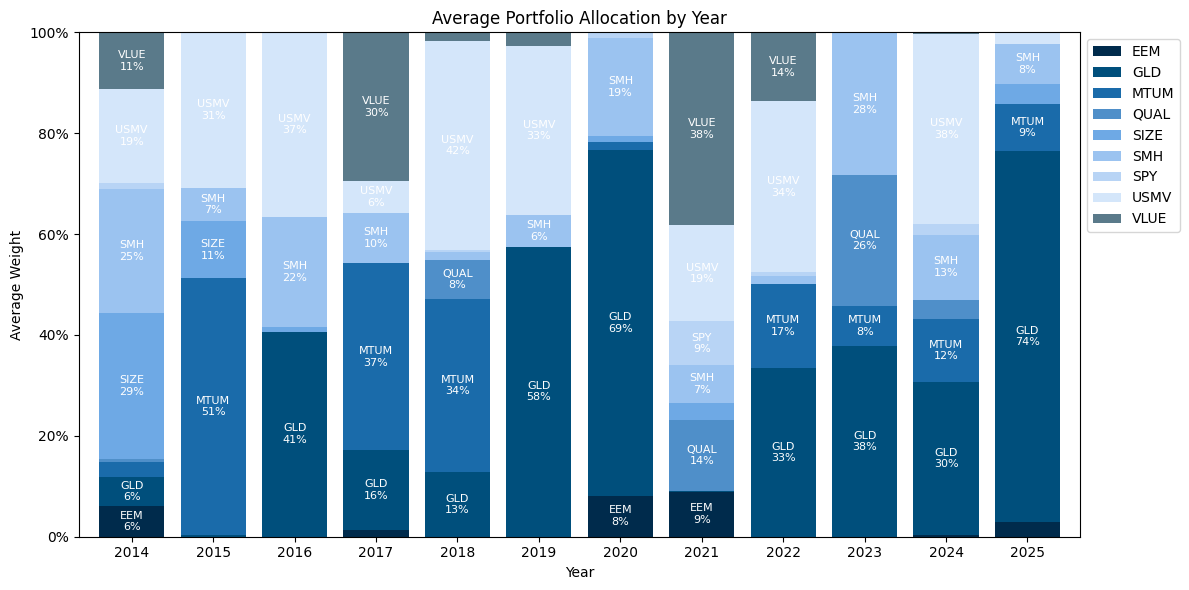

In [9]:
yearly_weights = weights.copy()
yearly_weights["Cash"] = 1 - yearly_weights[sorted(ASSETS)].sum(axis=1)
yearly_weights["Year"] = yearly_weights.index.year

start_idx = weights.sum(axis=1).gt(0).idxmax()
yearly_weights = yearly_weights.loc[start_idx:]

avg_alloc = yearly_weights.groupby("Year")[sorted(ASSETS) + ["Cash"]].mean()
avg_alloc = avg_alloc.loc[:, (avg_alloc > 0.01).any()]  # drop negligible

avg_alloc = avg_alloc[avg_alloc.index != 2013]

colors_alloc = ['#002B4C', '#004F7C', '#1A6BAA', '#4F8FC9', '#6EA9E5', '#9BC3F0', '#B8D4F5', '#D4E6FA', '#5A7A8A', '#A0A0A0']

fig, ax = plt.subplots(figsize=(12, 6))
avg_alloc.plot(kind='bar', stacked=True, ax=ax, color=colors_alloc[:len(avg_alloc.columns)], width=0.8)

for i, year in enumerate(avg_alloc.index):
    cumsum = 0
    for asset in avg_alloc.columns:
        val = avg_alloc.loc[year, asset]
        if val > 0.05:
            ax.text(i, cumsum + val/2, f"{asset}\n{val:.0%}", ha='center', va='center', fontsize=8, color='white')
        cumsum += val

ax.set_title("Average Portfolio Allocation by Year")
ax.set_ylabel("Average Weight"); ax.set_xlabel("Year")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticklabels(avg_alloc.index, rotation=0)
plt.tight_layout(); plt.show()

#10 Cumulative Returns Plot

/tmp/ipython-input-4255928030.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${t:,.0f}' for t in ax.get_yticks()])


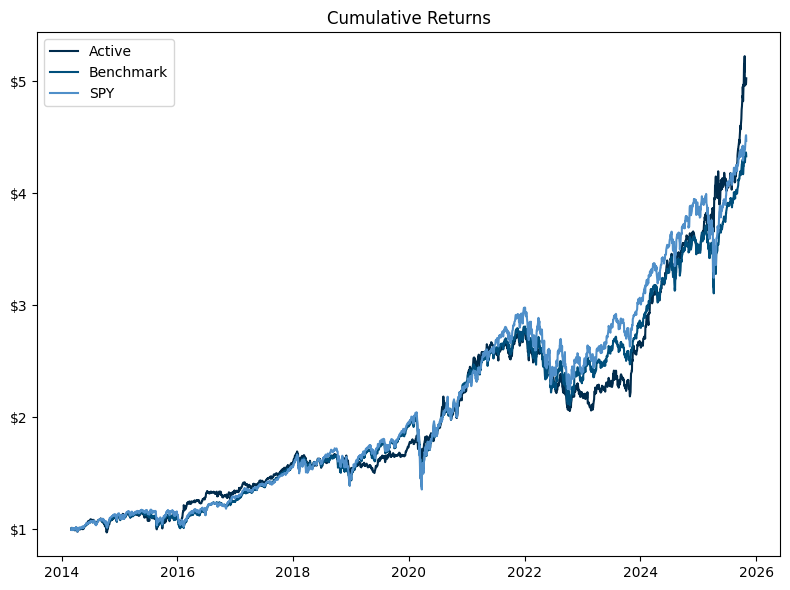

In [10]:
colors = {'Active': '#002B4C', 'Benchmark': '#004F7C', 'SPY': '#4F8FC9'}
plt.figure(figsize=(8, 6))
for name, ret in [("Active", active_ret), ("Benchmark", bench_ret), ("SPY", spy_ret)]:
    plt.plot((1+ret).cumprod(), label=name, color=colors[name])

plt.title("Cumulative Returns")
plt.legend()

ax = plt.gca()
ax.set_yticklabels([f'${t:,.0f}' for t in ax.get_yticks()])
plt.tight_layout()

plt.show()

#12 Rolling Sharpe Ratio and Max Drawdown

Rolling 252-day annualized Sharpe Ratio and Max Drawdown.

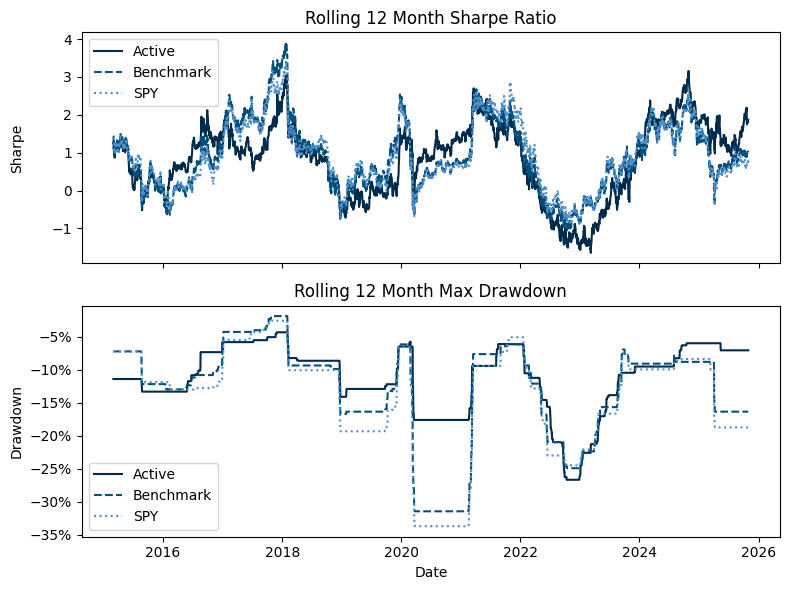

In [11]:
window_days = 252
rolling_vol = {n: r.rolling(window_days).std() * np.sqrt(252) for n, r in [("Active", active_ret), ("Benchmark", bench_ret), ("SPY", spy_ret)]}
excess = {n: r - rf_slice for n, r in [("Active", active_ret), ("Benchmark", bench_ret), ("SPY", spy_ret)]}
rolling_sharpe = {n: (excess[n].rolling(window_days).mean() * 252) / rolling_vol[n] for n in rolling_vol}

def rolling_mdd(ret, window):
    return ret.rolling(window).apply(lambda x: ((1+x).cumprod() / (1+x).cumprod().cummax() - 1).min(), raw=False)

rolling_dd = {n: rolling_mdd(r, window_days) for n, r in [("Active", active_ret), ("Benchmark", bench_ret), ("SPY", spy_ret)]}

styles = {"Active": ("-", '#002B4C'), "Benchmark": ("--", '#004F7C'), "SPY": (":", '#4F8FC9')}
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for n in styles:
    ls, c = styles[n]
    axes[0].plot(rolling_sharpe[n], ls=ls, color=c, label=n)
    axes[1].plot(rolling_dd[n], ls=ls, color=c, label=n)

axes[0].set_title("Rolling 12 Month Sharpe Ratio"); axes[0].set_ylabel("Sharpe"); axes[0].legend()
axes[1].set_title("Rolling 12 Month Max Drawdown"); axes[1].set_ylabel("Drawdown"); axes[1].legend()
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0)); axes[1].set_xlabel("Date")

# Align y-axes labels
fig.align_ylabels(axes)

plt.tight_layout(); plt.show()


#13 Rolling 12M vol of excess returns

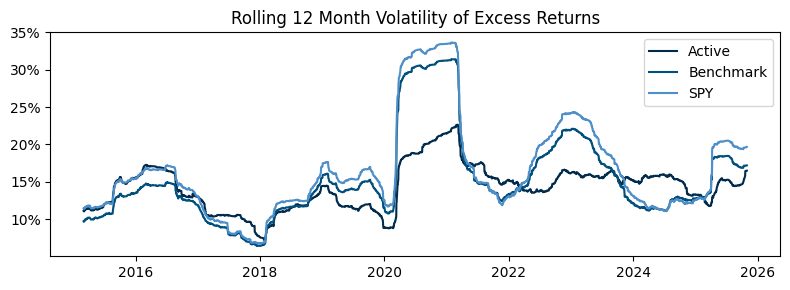

In [12]:
plt.figure(figsize=(8, 3))


for name, ret in [("Active", active_ret), ("Benchmark", bench_ret), ("SPY", spy_ret)]:
    plt.plot((ret - rf_slice).rolling(252).std() * np.sqrt(252), label=name, color=colors[name])
plt.title("Rolling 12 Month Volatility of Excess Returns")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
plt.legend()
plt.tight_layout()
plt.show()

#14 Portfolio Vol Plot

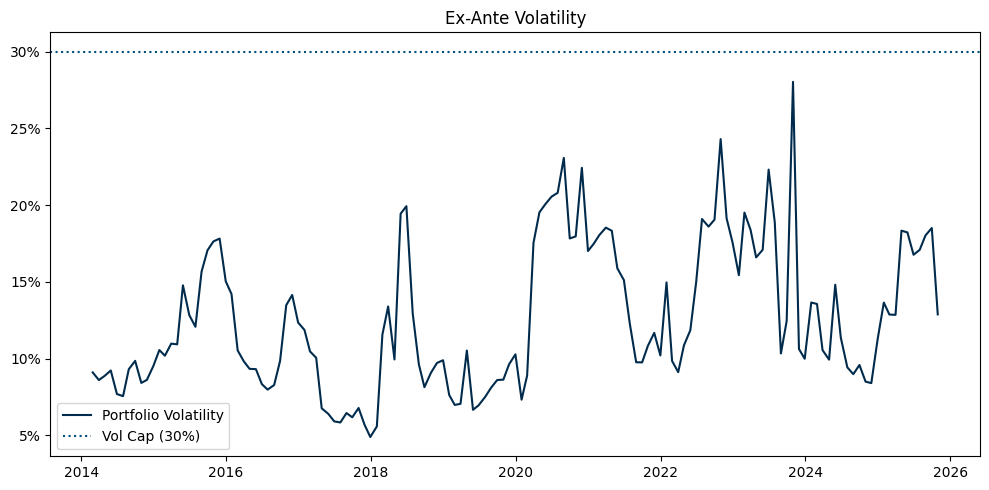

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(rebalance_df.index, rebalance_df["PostCapVol"], label="Portfolio Volatility", color='#002B4C')
plt.axhline(VOL_CAP, color="#004F7C", ls=":", label=f"Vol Cap ({VOL_CAP*100:.0f}%)")
plt.title("Ex-Ante Volatility")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
plt.legend()
plt.tight_layout()
plt.show()

#15 Fee Simulation
Shows effect of TER on Net CAGR.

In [14]:
gross_ret = active_ret - daily_fee
fee_range = np.linspace(0.00, 0.02, 6)

fee_df = pd.DataFrame({
    "Annual Fee": fee_range,
    "Net CAGR": [((1 + gross_ret + ((1-f)**(1/252)-1)).prod())**(252/len(gross_ret))-1 for f in fee_range]
})
fee_df.style.format({"Annual Fee": "{:.2%}", "Net CAGR": "{:.2%}"})

,Annual Fee,Net CAGR
0,0.00%,15.66%
1,0.40%,15.20%
2,0.80%,14.73%
3,1.20%,14.27%
4,1.60%,13.81%
5,2.00%,13.35%


#16 Lookback window and cap sensitvity
Simulates different lookback windows and vol caps.

In [15]:
def evaluate_params(lb, vc):
    w_local = pd.DataFrame(0.0, index=returns.index, columns=sorted(ASSETS))
    dates = [returns.index[returns.index.get_indexer([d], method="pad")[0]]
             for d in returns.resample("BME").last().index
             if returns.index.get_indexer([d], method="pad")[0] >= lb]
    dates = sorted(pd.unique(pd.to_datetime(dates)))

    for i, date in enumerate(dates):
        idx = returns.index.get_loc(date)
        window = slice(idx - lb, idx)
        valid = excess_returns.iloc[window].dropna(axis=1).columns
        if len(valid) == 0: continue

        w = tangency_weights(excess_returns[valid].iloc[window].mean(), returns[valid].iloc[window].cov())
        pvol = np.sqrt(w.values.dot((returns[valid].iloc[window].cov() * 252).dot(w.values)))
        w *= min(vc / pvol, 1.0) if pvol > 0 else 1.0

        end = dates[i+1] if i < len(dates)-1 else returns.index[-1]
        mask = (returns.index > date) & (returns.index <= end)
        w_local.loc[mask, w.index] = w.values

    risky = (w_local * returns).sum(axis=1)
    cash = (1 - w_local.sum(axis=1)).clip(0,1) * rf_daily
    ret = (risky + cash + daily_fee).loc[w_local.sum(axis=1).gt(0).idxmax():]
    rf = rf_daily.loc[ret.index]

    cagr = (1 + ret).prod()**(252/len(ret)) - 1
    vol = ret.std() * np.sqrt(252)
    sharpe = (ret.mean() - rf.mean()) / ret.std() * np.sqrt(252)
    return cagr, vol, sharpe

In [16]:
#Simulation Lookback
lb_results = [[lb, *evaluate_params(lb, VOL_CAP)] for lb in [63, 84, 126, 168, 189, 210, 252, 300]]
lb_df = pd.DataFrame(lb_results, columns=["Lookback", "CAGR", "Vol", "Sharpe"])
lb_df.style.format({"CAGR": "{:.2%}", "Vol": "{:.2%}", "Sharpe": "{:.2f}"})

,Lookback,CAGR,Vol,Sharpe
0,63,11.16%,14.32%,0.69
1,84,10.46%,14.45%,0.64
2,126,14.86%,14.57%,0.90
3,168,11.79%,14.56%,0.72
4,189,11.37%,15.37%,0.66
5,210,12.38%,14.72%,0.74
6,252,13.57%,15.38%,0.78
7,300,11.49%,15.49%,0.66


In [17]:
#Simulation Vol cap
vc_results = [[f"{vc*100:.0f}%", *evaluate_params(LOOKBACK, vc)] for vc in [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.30]]
vc_df = pd.DataFrame(vc_results, columns=["Vol Cap", "CAGR", "Vol", "Sharpe"])
vc_df.style.format({"CAGR": "{:.2%}", "Vol": "{:.2%}", "Sharpe": "{:.2f}"})

,Vol Cap,CAGR,Vol,Sharpe
0,10%,10.10%,11.33%,0.75
1,12%,11.34%,12.36%,0.79
2,14%,12.39%,13.15%,0.82
3,16%,13.17%,13.74%,0.84
4,18%,13.96%,14.22%,0.87
5,20%,14.34%,14.42%,0.88
6,22%,14.54%,14.49%,0.89
7,30%,14.86%,14.57%,0.90
